In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
# Upload all datasets
word_recognition = pd.read_csv("filtered_word_recognition.csv")

In [3]:
word_recognition

,user_id,voucher,valid,language,word,given_response_choice_old_new,given_response_choice_alive_manmade,wasOld_new,was_in_alive_manmade_list
0,10150,1,1,0,OYSTER,2,NaN,0,0.0
1,10150,1,1,0,BEE,4,4.0,0,0.0
2,10150,1,1,0,RABBIT,2,NaN,1,NaN
3,10150,1,1,0,MULE,2,NaN,1,NaN
4,10150,1,1,0,DRUM,1,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...
37395,10440,1,1,0,RAT,1,NaN,0,0.0
37396,10440,1,1,0,CAPITAL,1,NaN,1,NaN
37397,10440,1,1,0,SHEEP,5,1.0,0,0.0
37398,10440,1,1,0,SHED,1,NaN,0,1.0


# 1. ACC

Calculate the accuracy or precision of the users, taken from the percentage calculated from the ‘wc_percents’ table.

The results represent the following:
- If ACC = 1 (100%) -> The user answered all words correctly.
- If ACC = 0.5 (50%) -> The user got half of the words right.
- If ACC ≈ 0.0 -> The user performed very poorly.

In [3]:
# Define the Shannon Information function
def shannon_information(acc):
    if acc == 0:  # If accuracy is 0, return -1
        return -1
    elif acc == 1:  # If accuracy is 1, return 1
        return 1
    return np.sign(acc - 0.5) * (
        acc * np.log2(2 * acc) + (1 - acc) * np.log2(2 * (1 - acc))
    )

In [4]:
# Function to evaluate correct answers in Old-New
def is_correct_response_old_new(row):
    if row['given_response_choice_old_new'] == 3:  # Ambiguous, we ignore it
        return None  
    if row['wasOld_new'] == 1:  # Old word
        return row['given_response_choice_old_new'] in [4, 5]
    elif row['wasOld_new'] == 0:  # New word
        return row['given_response_choice_old_new'] in [1, 2]
    return False

In [5]:
# Function to evaluate correct answers in Alive-Manmade
def is_correct_response_alive_manmade(row):
    if pd.isna(row['given_response_choice_alive_manmade']):  # If there is no response, we ignore
        return None
    if row['given_response_choice_alive_manmade'] == 3.0:  # Ambiguous, we ignore it
        return None  
    if row['was_in_alive_manmade_list'] == 1:  # It's really Alive
        return row['given_response_choice_alive_manmade'] in [1.0, 2.0]
    elif row['was_in_alive_manmade_list'] == 0:  # It's really Manmade
        return row['given_response_choice_alive_manmade'] in [4.0, 5.0]
    return False

In [6]:
# Apply the functions to both classifications
word_recognition['is_correct_old_new'] = word_recognition.apply(is_correct_response_old_new, axis=1)
word_recognition['is_correct_alive_manmade'] = word_recognition.apply(is_correct_response_alive_manmade, axis=1)

# Filter by eliminating ambiguous answers
df_filtered = word_recognition.dropna(subset=['is_correct_old_new', 'is_correct_alive_manmade'], how='all')

# Calculate ACC per user for both ratings
user_acc = df_filtered.groupby('user_id')[['is_correct_old_new', 'is_correct_alive_manmade']].mean().reset_index()
user_acc.columns = ['user_id', 'ACC_Old_New', 'ACC_Alive_Manmade']

# Calculate WR_information for both classifications
user_acc['WR_information_Old_New'] = user_acc['ACC_Old_New'].apply(shannon_information)
user_acc['WR_information_Alive_Manmade'] = user_acc['ACC_Alive_Manmade'].apply(shannon_information)

user_acc

,user_id,ACC_Old_New,ACC_Alive_Manmade,WR_information_Old_New,WR_information_Alive_Manmade
0,103,0.592965,0.400000,0.025083,-0.029049
1,104,0.132530,0.583333,-0.435664,0.020131
2,105,0.404494,0.470588,-0.026481,-0.002497
3,1012,0.170330,0.480000,-0.341542,-0.001154
4,1014,0.066667,0.672269,-0.646641,0.087409
...,...,...,...,...,...
180,10434,0.181250,0.586207,-0.317196,0.021551
181,10435,0.083333,0.547009,-0.586183,0.006386
182,10436,0.350000,0.333333,-0.065932,-0.081704
183,10437,0.189944,0.490566,-0.298645,-0.000257


# GRAPHS

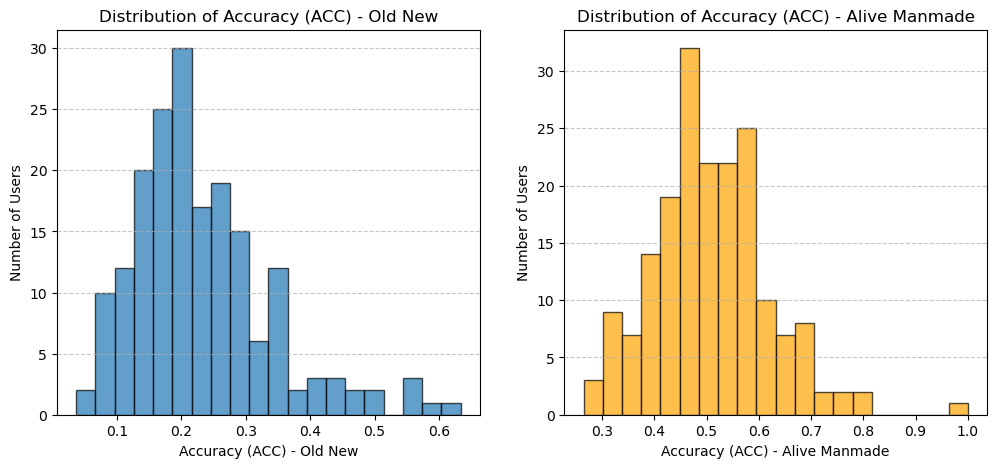

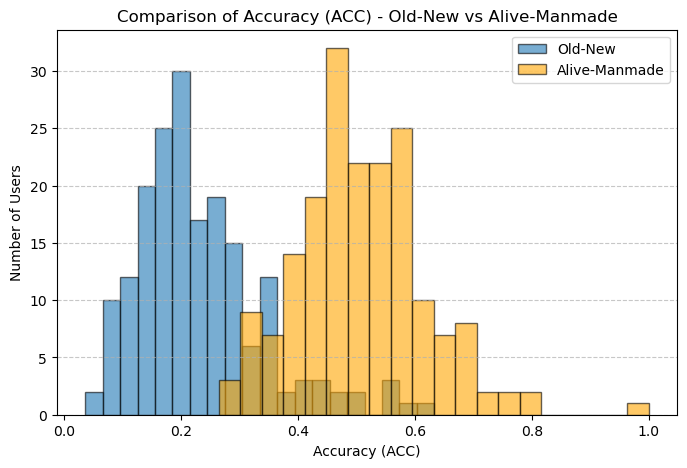

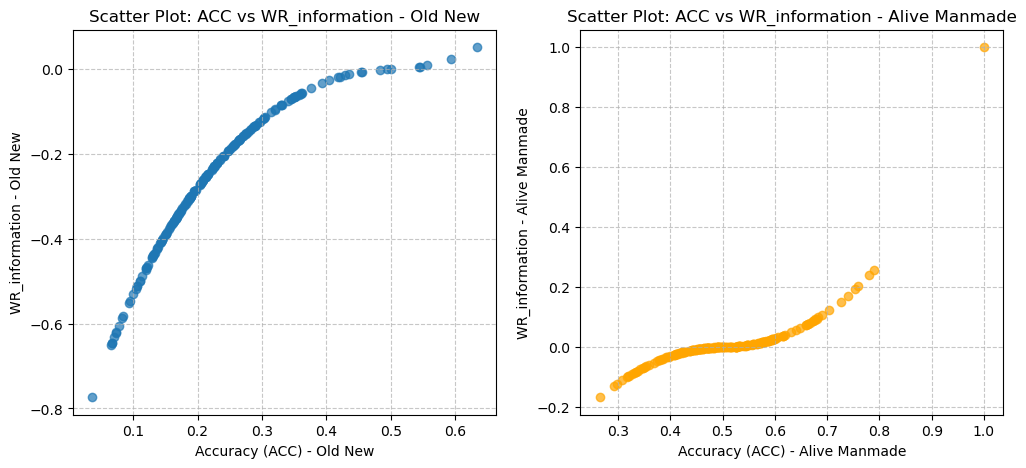

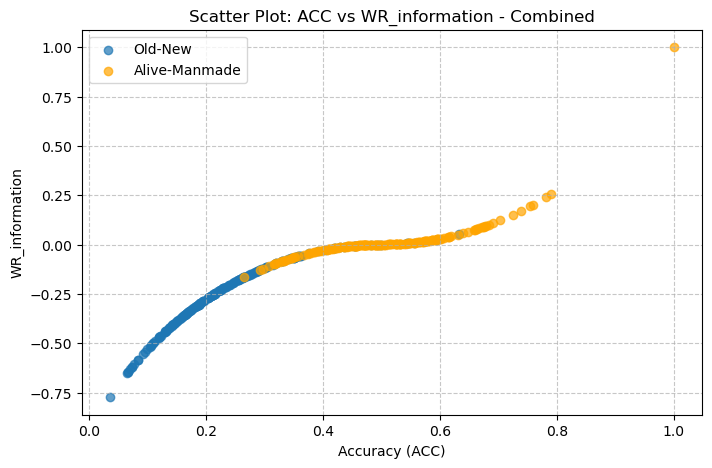

In [7]:
# 1. Separate CCA histograms (Old-New and Alive-Manmade)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(user_acc['ACC_Old_New'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Accuracy (ACC) - Old New')
plt.ylabel('Number of Users')
plt.title('Distribution of Accuracy (ACC) - Old New')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.hist(user_acc['ACC_Alive_Manmade'], bins=20, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Accuracy (ACC) - Alive Manmade')
plt.ylabel('Number of Users')
plt.title('Distribution of Accuracy (ACC) - Alive Manmade')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

# 2. Combined CCA histogram
plt.figure(figsize=(8, 5))
plt.hist(user_acc['ACC_Old_New'], bins=20, edgecolor='black', alpha=0.6, label="Old-New")
plt.hist(user_acc['ACC_Alive_Manmade'], bins=20, edgecolor='black', alpha=0.6, label="Alive-Manmade", color='orange')
plt.xlabel('Accuracy (ACC)')
plt.ylabel('Number of Users')
plt.title('Comparison of Accuracy (ACC) - Old-New vs Alive-Manmade')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Scatter plots of ACC vs WC_information
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(user_acc['ACC_Old_New'], user_acc['WR_information_Old_New'], alpha=0.7)
plt.xlabel('Accuracy (ACC) - Old New')
plt.ylabel('WR_information - Old New')
plt.title('Scatter Plot: ACC vs WR_information - Old New')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.scatter(user_acc['ACC_Alive_Manmade'], user_acc['WR_information_Alive_Manmade'], alpha=0.7, color='orange')
plt.xlabel('Accuracy (ACC) - Alive Manmade')
plt.ylabel('WR_information - Alive Manmade')
plt.title('Scatter Plot: ACC vs WR_information - Alive Manmade')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

# Combined scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(user_acc['ACC_Old_New'], user_acc['WR_information_Old_New'], alpha=0.7, label="Old-New")
plt.scatter(user_acc['ACC_Alive_Manmade'], user_acc['WR_information_Alive_Manmade'], alpha=0.7, label="Alive-Manmade", color='orange')
plt.xlabel('Accuracy (ACC)')
plt.ylabel('WR_information')
plt.title('Scatter Plot: ACC vs WR_information - Combined')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<u>Graphical Interpretation:</u>

**1. Separate CCA histograms (Old-New and Alive-Manmade):** They show the distribution of accuracy in each task. It is observed that users in the "Alive-Manmade" task tend to have higher accuracy than in "Old-New".

**2. Combined CCA histogram:** It compares the pressure in both tasks. "Alive-Manmade" has a higher peak accuracy compared to "Old-New".

**3. Scatter plots of ACC vs WC_information:** "Old-New" shows a positive relationship, where more ACC indicates more information processed, while "Alive-Manmade" has a similar relationship, but with more accurate users.

**4. Combined scatter plot:** It compares both tasks in a single graph and also shows that the distribution of "Alive-ManMade" is shifted more to the right (higher accuracy).